# Tarea 2 - MEL

Alejandro Mantilla - 201711304

Ximena Palacio - 201730995

## Índice

- [Parte A](#Parte-A.-Problemas-Computacionales.)

    - [Problema 1](#Problema-1.-Escriba-su-propia-función-para-hacer-pruebas-sobre-los-betas.)
    - [Problema 2](#Problema-2.-Visualizando-las-regiones-de-confianza.)

- [Parte B](#Parte-B.-Problemas-Teóricos-y-Conceptuales.)

    - [Problema 3](#Problema-3.-Formas-de-variables-dummies.)
    
- [Parte C](#Parte-C.-Problemas-Aplicados-con-Datos-Reales.)

    - [Problema 4](#Problema-4.-Modelos-No-Lineales.)
    - [Problema 5](#Problema-5.-Efectos-de-la-personalidad-en-la-producción-intelectual-bajo-estrés.)
    - [Problema 6](#Problema-6.-Interacciones-y-Multicolinealidad.)

## Parte A. Problemas Computacionales.

### Problema 1. Escriba su propia función para hacer pruebas sobre los betas.

Como ya lo vimos en clase, las pruebas $F$ para restricciones en los parámetros $\beta$ de la recta incluyen
la mayor parte de las pruebas que se pueden hacer sobre los modelos de regresión (significancia global,
significancia de cada variable, combinaciones lineales, etc).

Como habrá visto, la función `lm` de R no tiene la opción de inferir sobre restricciones generales, sino
que hace la prueba de significancia global y las individuales.

Lea el capítulo 10 del documento de introducción a R (`intro-R.pdf`) sobre cómo crear sus propias
funciones, y con esto:

#### 1. Cree su propia función para estimar un modelo de regresión lineal en donde los inputs son: matriz $X$, vector $Y$, el vector $c$, la matriz $A$ (si se quiere hacer una prueba general con restricciones) y el vector de subíndices que se quieren incluir en la hipótesis nula de una prueba de significancia parcial. Puede usar como base las funciones vistas en clase, si lo prefiere.

#### 2. La función debe tener una entrada binaria en la que el usuario decida si quiere hacer una prueba con restricciones generales o una significancia parcial.

#### 3. La función debe dar como salida: la prueba de significancia global, las significancias individuales de cada uno de los betas (con pruebas de hipótesis o intervalos de confianza) y el resultado de la prueba asociada a $A$ o a los índices de los betas en la prueba parcial, incluyendo el _$p$-value_.

#### 4. Póngale el nombre de su preferencia a la función, añádale los demás atributos que quiera y úsela a su conveniencia.

Definimos la función, y la probamos a partir deun ejemplo sencillo con los datos de marketing del paquete `datarium`.

In [1]:
hipotesis_tests <- function(X,
                            y,
                            partial_tests = FALSE,
                            indices = NULL,
                            A = NULL,
                            c = NULL) {

    p_val <- function(X, y, n, p, q, A, c) {

        xtx <- t(X) %*% X
        H <- solve(xtx)

        beta_hat <- H %*% t(X) %*% y

        y_hat <- X %*% beta_hat

        s2 <- sum((y - y_hat) ^ 2) / (n - p)

        beta_r <- beta_hat +
                  (H %*% t(A)
                   %*% solve(A %*% H %*% t(A))
                   %*% (c - (A %*% beta_hat)))

        ep <- (sum((y_hat - (X %*% beta_r)) ^ 2) / q) / s2

        pvalue <- 1 - pf(ep, q, (n - p))

        return(c(ep, pvalue))

    }

    result <- list()

    if (!partial_tests) {

        n <- nrow(X)
        p <- ncol(X)
        q <- nrow(A)

        result$restricted <- paste("(ep, pvalue):", p_val(X, y, n, p, q, A, c))

    } else {

        n <- nrow(X)
        p <- ncol(X)

        indices <- which(colnames(X) %in% indices)

        q <- length(unique(indices))

        A <- diag(1, p)[indices, ]
        c <- matrix(rep(0, q), ncol = 1)

        result$partial <- paste("(ep, pvalue):", p_val(X, y, n, p, q, A, c))

    }

    n <- nrow(X)
    p <- ncol(X)

    q <- p - 1

    A <- cbind(0, diag(1, q))
    c <- matrix(0, nrow = q)

    result$global <- paste("(ep, pvalue):", p_val(X, y, n, p, q, A, c))

    result$marginal <- list()

    for(i in 2:p) {

        result$marginal[[paste("marginal", colnames(X)[i], sep = "_")]] <- paste("(ep, pvalue):", p_val(X, y, n, p, q, A[i - 1, , drop = FALSE], c[i - 1, , drop = FALSE]))

    }

    return(result)

}

In [2]:
data("marketing", package = "datarium")

X <- marketing[, c("youtube", "facebook", "newspaper")]
X <- as.matrix(cbind(1, X))
y <- as.matrix(marketing["sales"])

# Partial (facebook = youtube = 0):
print("Prueba parcial.")
hipotesis_tests(X = X, y = y, partial_tests = TRUE,
                indices = c("facebook", "youtube"))

# Compund (facebook = youtube):
print("Prueba restringida.")
A <- matrix(c(0, 1, -1, 0), nrow = 1)
c <- matrix(0)
hipotesis_tests(X, y, partial_tests = FALSE, A = A, c = c)


[1] "Prueba parcial."


$partial
[1] "(ep, pvalue): 805.714107187276" "(ep, pvalue): 0"               

$global
[1] "(ep, pvalue): 570.270703659095" "(ep, pvalue): 0"               

$marginal
$marginal$marginal_youtube
[1] "(ep, pvalue): 358.801945611961" "(ep, pvalue): 0"               

$marginal$marginal_facebook
[1] "(ep, pvalue): 159.775056548176" "(ep, pvalue): 0"               

$marginal$marginal_newspaper
[1] "(ep, pvalue): 0.0104093483677209" "(ep, pvalue): 0.998540630496386"

[1] "Prueba restringida."


$restricted
[1] "(ep, pvalue): 264.724159608646" "(ep, pvalue): 0"               

$global
[1] "(ep, pvalue): 570.270703659095" "(ep, pvalue): 0"               

$marginal
$marginal$marginal_youtube
[1] "(ep, pvalue): 358.801945611961" "(ep, pvalue): 0"               

$marginal$marginal_facebook
[1] "(ep, pvalue): 159.775056548176" "(ep, pvalue): 0"               

$marginal$marginal_newspaper
[1] "(ep, pvalue): 0.0104093483677209" "(ep, pvalue): 0.998540630496386"

### Problema 2. Visualizando las regiones de confianza.

Hasta ahora sabemos hacer intervalos de confianza asociados a cada uno de los parámetros $\beta_{j}$ para $j = 0, 1, \cdots , k$. Sin embargo, estos están relacionados a pruebas individuales, con conjuntas. Para solucionar esto, vamos a hacer regiones conjuntas de confianza para pares de parámetros. Para esto, tenga en cuenta que cada par de estimadores $\hat{\beta}_{i}$ y $\hat{\beta}_{i}$ para $i, j \in \{0, . . . , k\}$ se distribuyen como un vector normal bivariado (revisar las propiedades de la distribución normal multivariada), Esto es:

$$
  \left( \hat{\beta}_{i}, \hat{\beta}_{i}\right)^{T} \sim \mathcal{N}_{2}\left(\left( \beta_{i}, \beta_{i}\right)^{T}, \sigma^{2}\textbf{W}_{ij}\right).
$$

Donde la matriz $\textbf{W}_{ij}$ corresponde a los elementos correspondientes a las varianza y covarianza, esto es:

$$
  \textbf{W}_{ij} =
  \begin{bmatrix}
    h_{ii} & h_{ij}\\
    h_{ij} & h_{jj}
  \end{bmatrix}.
$$

Para construir el la región de confianza siga los siguientes pasos:

#### 1. Determine la distribución de:

$$
  \sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Llegamos a la expresión deseada, estandarizando los estimadores. Estandarizar las distribuciones marginales también estandariza la distribución conjunta.

\begin{align*}
  \begin{bmatrix}
    \hat{\beta}_{i}\\
    \hat{\beta}_{j}
  \end{bmatrix} &\sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    \beta_{i}\\
    \beta_{j}
  \end{bmatrix}, \sigma^{2}\textbf{W}_{ij}\right) \\
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i} \\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} &\sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    0\\
    0
  \end{bmatrix}, \sigma^{2}\textbf{W}_{ij}\right)
\end{align*}

$$
  \left[ \sigma^{2}\textbf{W}_{ij} \right]^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
  = \sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
  \sim \mathcal{N}_{2}\left(
  \begin{bmatrix}
    0\\
    0
  \end{bmatrix},
  \begin{bmatrix}
    1 & 0\\
    0 & 1
  \end{bmatrix}\right).
$$

La expresión se distribuye normal estándar bivariada.

#### 2. Determine la distribución de:

$$
  \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Usaremos la propiedad de simetría de la matriz $\textbf{W}_{ij}$: $\left[\textbf{W}_{ij}\right]^{T} = \textbf{W}_{ij}$.

Tomamos dos características que demostramos en la tarea anterior. Si $Y\sim\mathcal{N}(0,1)$, entonces:

-   $Y^{2}\sim\chi^{2}(1)$, y
-   $\sum_{i = 1}^{n}Y_{i}^{2}\sim\chi^{2}(n)$.

Por lo mismo, podemos ver que si $\begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} \sim \mathcal{N}_{2}(0,1)$, entonces:

$$
  \begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} ^{2} = \begin{bmatrix} Y_{1} & Y_{2} \end{bmatrix}\begin{bmatrix} Y_{1} \\ Y_{2} \end{bmatrix} = Y_{1}^{2} + Y_{2}^{2} = \sum_{i = 1}^{2} Y_{i}^{2} \sim \chi^{2}(2).
$$

La consecuencia de esta propiedad es que:

$$
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{2} \sim \chi^{2}(2).
$$

Desarrollamos esta propiedad hasta alcanzar la expresión deseada.


\begin{align*}
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{2} &=
  \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right]^{T} \left[\sigma^{-1}\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right] \\
  &= \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \left[\textbf{W}_{ij}^{-\frac{1}{2}}\right]^{T} \left[\textbf{W}_{ij}^{-\frac{1}{2}}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}\right] \\
  &= \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} \sim \chi^{2}(2).
\end{align*}

#### 3. Como la varianza del error ($\sigma^{2}$) no se conoce, determine la distribución de:

$$
  \left(\frac{1}{2\cdot MSE}\right)
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}
$$

Por el teorema de Cochran, $\frac{SSE}{\sigma^{2}}\sim\chi^{2}(n-2)$.

Sean $S_{1} \sim \chi^{2}(d_{1})$ y $S_{2} \sim \chi^{2}(d_{2})$, entonces $\frac{S_{1}/d_{1}}{S_{2}/d_{2}} \sim F(d_{1}, d_{2})$.

Construimos una distribución $F$ de la misma manera:

$$
  S_{1} := \sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}.\\
  S_{1}\sim \chi^{2}(2) \implies d_{1} = 2.
$$

$$
  S_{2} := \frac{SSE}{\sigma^{2}}. \\
  S_{2} \sim \chi^{2}(n-2) \Rightarrow d_{2} = n-2.
$$

$$
  \frac{\sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} / 2}{\frac{SSE}{\sigma^{2}} / (n-2)} \sim F(2, n-2).
$$

$$
  \frac{\sigma^{-2}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T} \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix} / 2}{\frac{SSE}{\sigma^{2}} / (n-2)} = 
  \frac{\begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}^{T}
  \textbf{W}_{ij}^{-1}
  \begin{bmatrix}
    \hat{\beta}_{i} - \beta_{i}\\
    \hat{\beta}_{j} - \beta_{j}
  \end{bmatrix}}{2\cdot MSE}.
$$

#### 4. Use la expresión del numeral anterior para definir una región (en este caso una elipse) que forma una región bidimensional con una confianza de $1-\alpha$.

Suponemos un intervalo de confianza conjunto sobre el estadístico F de cola superior.

La expresión del literal anterior define la forma cuadrática:
\begin{align*}
  f\left(\beta_{i},\beta_{j}\right) &= \frac{\begin{bmatrix}
      \hat{\beta}_{i} - \beta_{i}\\
      \hat{\beta}_{j} - \beta_{j}
    \end{bmatrix}^{T}
    \textbf{W}_{ij}^{-1}
    \begin{bmatrix}
      \hat{\beta}_{i} - \beta_{i}\\
      \hat{\beta}_{j} - \beta_{j}
    \end{bmatrix}}{2\cdot MSE} \\ 
    &= \frac{h_{jj}\left( \hat{\beta}_{i} -\beta_{i}\right)^{2} - 2h_{ij}\left( \hat{\beta}_{i} -\beta_{i}\right)\left( \hat{\beta}_{j} -\beta_{j}\right) + h_{ii}\left( \hat{\beta}_{j} -\beta_{j}\right)^{2}}{2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE} \\
\end{align*}

Si se acota de la siguiente manera, esta forma cuadrática describe una región que satisface el intervalo de confianza en forma de elipse:

$$
\frac{h_{jj}\left( \hat{\beta}_{i} -\beta_{i}\right)^{2} - 2h_{ij}\left( \hat{\beta}_{i} -\beta_{i}\right)\left( \hat{\beta}_{j} -\beta_{j}\right) + h_{ii}\left( \hat{\beta}_{j} -\beta_{j}\right)^{2}}{2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE} \leq F_{1-\alpha}(2,n-2).
$$

Expandimos la forma cuadrática hasta llegar a la forma general: $ax^{2} + by^{2} + cxy + dx + ey + f \leq 0$. Esto nos va a permitir graficar la elipse de manera más sencilla ya que conoceerémos la longitud de sus ejes y cuanto espacio debería ocupar en el gráfico.

$$
  h_{jj}\left( \hat{\beta}_{i}^{2} - 2\hat{\beta}_{i}\beta_{i} + \beta_{i}^{2}\right) - 2h_{ij}\left( \hat{\beta}_{i}\hat{\beta}_{j} + \beta_{i}\beta_{j} - \hat{\beta}_{i}\beta_{j} - \hat{\beta}_{j}\beta_{i} \right) + h_{ii}\left( \hat{\beta}_{j}^{2} - 2\hat{\beta}_{j}\beta_{j} + \beta_{j}^{2}\right) \leq 2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE \cdot F_{1-\alpha}(2,n-2)\\
  h_{jj}\beta_{i}^{2} + h_{ii}\beta_{j}^{2} - 2h_{ij}\beta_{i}\beta_{j} + \left(2h_{ij}\hat{\beta}_{j} - 2h_{jj}\hat{\beta}_{i}\right)\beta_{i} + \left(2h_{ij}\hat{\beta}_{i} - 2h_{ii}\hat{\beta}_{j}\right)\beta_{j} - 2h_{ij}\hat{\beta}_{i}\hat{\beta}_{j} + h_{jj}\hat{\beta}_{i}^{2} + h_{ii}\hat{\beta}_{j}^{2} - 2 \cdot (h_{ii}h_{jj}-h_{ij}^{2}) \cdot MSE \cdot F_{1-\alpha}(2,n-2) \leq 0.
$$

En esta región, $F_{1 - \alpha}(2,n-2)$ es el percentil para un porcentaje $\alpha$ de cola izquierda de una distribución $F(2,n-2)$.

#### 5 & 6. Investigue la función contour de R, y úsela para graficar la región (elipse) de confianza dados los valores $\hat{\beta}_{i}$, $\hat{\beta}_{j}$, $\textbf{W}_{ij}$ y el $MSE$. Puede usar cualquier otra función que considere pertinente para graficar. Cree una función donde los inputs son los datos X, Y, el nivel de significancia ($\alpha$) y el par de parámetros betas (por ejemplo $\beta_{1}$ y $\beta_{3}$). Como resultado de la función, se debe producir un gráfico con la elipse de confianza para los dos parámetros seleccionados.

In [3]:
# Los parámetros alpha y n son desconocidos y deberían ser registrados por el usuario.
# Sus valores por defecto son para poder correr la función con instancias de prueba.
ellipse_contour <- function(beta_hat_i, beta_hat_j, W_ij, MSE, alpha = 0.05, n = 1000){
  # Producimos los parámetros de la forma general de la elipse (a * x ^ 2 + b * y ^ 2 + c * x * y + d * x + e * y + f < 0).
  a <- W_ij[2, 2]
  b <- W_ij[1, 1]
  c <- -2*W_ij[1,2]
  d <- 2*W_ij[1,2]*beta_hat_j - 2*W_ij[2,2]*beta_hat_i
  e <- 2*W_ij[1,2]*beta_hat_i - 2*W_ij[1,1]*beta_hat_j
  f <- -2*W_ij[1,2]*beta_hat_i*beta_hat_j + W_ij[2,2]*beta_hat_i^2 + W_ij[1,1]*beta_hat_j^2 - 2*(W_ij[1,1]*W_ij[2,2] - W_ij[1,2]^2) * MSE * qf(1-alpha, 2, n-2)

  # Definimos una función que grafica elipses a partir de sus parámetros.
  plot.ellipse <- function (a, b, c, d, e, f, n) {
    ## solve for centre
    A <- matrix(c(a, c / 2, c / 2, b), 2L)
    B <- c(-d / 2, -e / 2)
    mu <- solve(A, B)
    ## generate points on circle
    r <- sqrt(a * mu[1] ^ 2 + b * mu[2] ^ 2 + c * mu[1] * mu[2] - f)
    theta <- seq(0, 2 * pi, length = n)
    v <- rbind(r * cos(theta), r * sin(theta))
    ## transform for points on ellipse
    z <- backsolve(chol(A), v) + mu
    ## plot points
    plot(t(z), type = "l")
  }

  # Graficamos la elipse.
  plot.ellipse(a, b, c, d, e, f, n)
}

Hacemos un ejemplo sencillo con los datos de marketing del paquete `datarium`. Para estos datos vamos a computar la matriz de covarianzas de los beta seleccionados y el MSE del modelo. Haremos este procedimiento según los lineamientos del literal 6.

In [4]:
data("marketing", package = "datarium")
head(marketing)
X <- marketing[, c("youtube", "facebook", "newspaper")]
y <- marketing["sales"]

,youtube,facebook,newspaper,sales
,<dbl>,<dbl>,<dbl>,<dbl>
1,276.12,45.36,83.04,26.52
2,53.40,47.16,54.12,12.48
3,20.64,55.08,83.16,11.16
4,181.80,49.56,70.20,22.20
5,216.96,12.96,70.08,15.48
6,10.44,58.68,90.00,8.64


Crearemos una función que reciba estos datos, calcule los valores necesarios y llame a la función `ellipse_contour` que creamos antes.

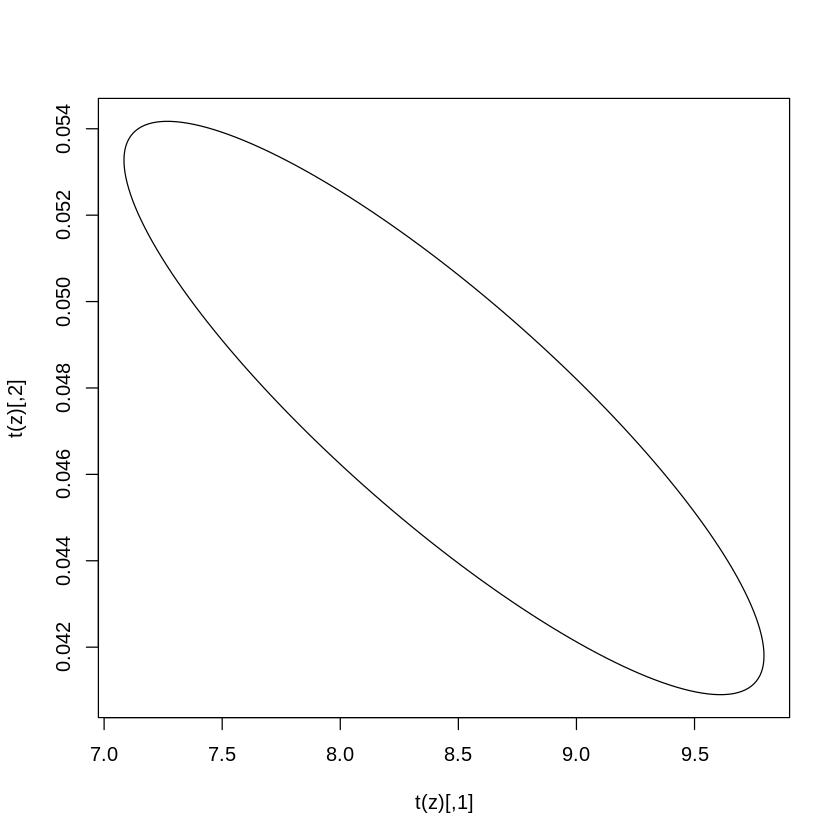

In [5]:
# Los parámetros beta_index_1 y beta_index_2 son enteros
# de 0 a k, con k cantidad de variables.
ellipse_from_data <- function(X, y, alpha = 0.05, beta_index_1, beta_index_2){
  X <- as.matrix(cbind(intercept = 1, X))
  X <- X[,c(beta_index_1, beta_index_2)]
  y <- as.matrix(y)
  n <- length(y)
  cov.mat <- solve(t(X) %*% X)
  coeff <- cov.mat %*% t(X) %*% y
  MSE <- sum((X %*% coeff - y) ^ 2) / (n - 2)
  ellipse_contour(coeff[1], coeff[2], cov.mat, MSE, alpha, n)
}

ellipse_from_data(X, y, 0.05, 1, 2)

## Parte B. Problemas Teóricos y Conceptuales.

### Problema 3. Formas de variables dummies.

Lo primero que se debe hacer es plantear el modelo utilizando los datos de `Carseats`.
$$x_1 = \ {Income} $$
$$x_2 = \ {Advertising} $$
$$z = \ {ShelveLoc} $$

Dado que la variable $z$ es una variable catergótica, el modelo tiene multicolinealidad y por ende no se puese estimar por lo que se debe utilizar una clase base. Para efectos de este punto se pide que se utilice la parametrización con restricción de suma cero. 
Para lo anterior se utiliza como blase base "bad" y la codificación quedaría de la siguiente manera: 

\begin{equation}
z_m = 
\left\{
    \begin{array}{lr}
        1, \ \textit{caso de posición medium} \\
        \frac{-n_m}{n_b} ,\ \textit{caso de posición bad} \\
        0,{dlc}
    \end{array}
    \right\} 
\end{equation}

\begin{equation}
z_g = 
\left\{
    \begin{array}{lr}
        1, \ \textit{caso de posición good} \\
        \frac{-n_g}{n_b} ,\ \textit{caso de posición bad} \\
        0,{dlc}
    \end{array}
    \right\} 
\end{equation}

Teniendo en cuenta las restricciones se considera el siguiente modelo con todas las dummies y todas las interacciones:

$$
y=\beta_0 + \beta_1 x_1 +\beta_2 x_2 + \tau_1 z_m + \tau_2 z_g +\gamma_1 x_1 z_m +\gamma_2 x_1 z_g +\gamma_3 x_2 z_m ++\gamma_4 x_2 z_g + \epsilon
$$


In [6]:
#PUNTO 3
library(psych)
library(ISLR)

data <- Carseats

#Frecuencia
nm <- table(data$ShelveLoc)[3]
ng <- table(data$ShelveLoc)[2]
nb <- table(data$ShelveLoc)[1]

#Variables dummies
zm <- ifelse(data$ShelveLoc == "Medium", 1,ifelse(data$ShelveLoc == "Bad",-(nm/nb),0))
zg <- ifelse(data$ShelveLoc == "Good", 1,ifelse(data$ShelveLoc == "Bad",-(ng/nb),0))

#Modelo
y <- data$Sales
x1 <- data$Income
x2 <- data$Advertising
x1xzm <- x1 * zm
x1xzg <- x1 * zg
x2xzm <- x2 * zm
x2xzg <- x2 * zg

x<-cbind(x1, x2, zm, zg, x1xzm, x1xzg, x2xzm, x2xzg)
regresion<-lm(y~x1+x2+zm+zg+x1xzm+x1xzg+x2xzm+x2xzg)
summary(regresion)  


Call:
lm(formula = y ~ x1 + x2 + zm + zg + x1xzm + x1xzg + x2xzm + 
    x2xzg)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.1411 -1.6175  0.0447  1.5514  6.3020 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.717157   0.308247  18.547  < 2e-16 ***
x1           0.016629   0.003967   4.192 3.42e-05 ***
x2           0.095648   0.016672   5.737 1.93e-08 ***
zm          -0.436735   0.281770  -1.550    0.122    
zg           3.289884   0.595522   5.524 6.05e-08 ***
x1xzm        0.003513   0.003618   0.971    0.332    
x1xzg       -0.010079   0.007563  -1.333    0.183    
x2xzm        0.006748   0.015179   0.445    0.657    
x2xzg        0.007940   0.031565   0.252    0.802    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.203 on 391 degrees of freedom
Multiple R-squared:  0.4035,	Adjusted R-squared:  0.3913 
F-statistic: 33.06 on 8 and 391 DF,  p-value: < 2.2e-16


#### 1. ¿Es cierto que la posición en el estante no infuye sobre las ventas?

Para poder saber sí la posición del estante no influye en las ventas se plantea la siguiente prueba de hipótesis
$$
H_0:\tau_1 = \tau_2 = \gamma_1 = \gamma_2 = \gamma_3 = \gamma_4 = 0 
$$

$$
H_1: \tau_1 \neq 0 \ \  or \ \ \tau_2 \neq 0 \ \ or \ \ \gamma_1 \neq 0 \ \ or \ \ \gamma_2 \neq 0 \ \ or \ \ \gamma_3 \neq 0 \ \ or \ \ \gamma_4 \neq 0 \ \ 
$$

In [7]:
gtest <- function(x,y,A,c){
  n <- length(y)
  k <- dim(x)[2]
  p <- k + 1
  q <- dim(A)[1]
  xx <- cbind(rep(1,n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  yhat <- xx %*% beta  
  mse <- sum((y - yhat)^2)/(n - p)
  betaH <- beta + solve(t(xx) %*% xx) %*% t(A) %*% solve(A %*% solve(t(xx) %*% xx) %*% t(A)) %*% (c- A %*% beta)
  yhatH <- xx %*% betaH
  F <- (sum((y- yhatH)^2)-sum((y- yhat)^2))/q /mse
  pval <- 1-pf(F, q, n- p)
  return(list(F = F, pvalue = pval))
}

A <- matrix(c(0,0,0,1,0,0,0,0,0,
             0,0,0,0,1,0,0,0,0,
             0,0,0,0,0,1,0,0,0,
             0,0,0,0,0,0,1,0,0,
             0,0,0,0,0,0,0,1,0,
             0,0,0,0,0,0,0,0,1),ncol=9,byrow = T)     
     
c <-c(0,0,0,0,0,0)

gtest(x,y,A,c)

$F
[1] 34.12019

$pvalue
[1] 0

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, es decir que al menos una posición en el estante sí influye en las ventas. Pues el ${p value}<5 \% $ 

#### 2. ¿Es cierto que los modelos en todas las clases son paralelos (los efectos no cambian)?

Para poder saber si los modelos en todas las clases son paralelos, es decir que sus efectos no cambian se plantea la siguiente prueba de hipótesis 


$$
H_0:\gamma_1 = \gamma_2 = \gamma_3 = \gamma_4 = 0 
$$

$$
H_1:\gamma_1 \neq 0 \ \ or \ \ \gamma_2 \neq 0 \ \ or \ \ \gamma_3 \neq 0 \ \ or \ \ \gamma_4 \neq 0 \ \ 
$$

In [8]:
A <- matrix(c(0,0,0,0,0,1,0,0,0,
             0,0,0,0,0,0,1,0,0,
             0,0,0,0,0,0,0,1,0,
             0,0,0,0,0,0,0,0,1),
           ncol=9,byrow = T)


c <- c(0,0,0,0)

gtest(x,y,A,c)

$F
[1] 0.6020059

$pvalue
[1] 0.6614046

Con un nivel de confianza del 95% se puede concluir que se no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el modelo en todas sus clases es pararelo, es decir que en se puede afirmar que sus efectos no cambian, pues el ${p value}>5 \% $ 

#### 3. ¿Son los modelos para las ventas posición media en el estante, y para la posición buena iguales?

Para poder saber si los modelos para las ventas en la posicipon media del estante y la posición buena del estante son iguales, se plantea la siguiente prueba de hipótesis 

\begin{equation}
H_0 = 
\left\{
    \begin{array}{lr}
        \tau_1 = \tau_2\\
        \gamma_1 = \gamma_2\\
        \gamma_3 =  \gamma_4
    \end{array}
    \right\} 
\end{equation}

$$
H_1:\textit{Al menos una es diferente}
$$

In [9]:
A <- matrix(c(0,0,0,-1,1,0,0,0,0,
             0,0,0,0,0,-1,1,0,0,
             0,0,0,0,0,0,0,-1,1),ncol=9,byrow = T)
c <- c(0,0,0)

gtest(x,y,A,c)



$F
[1] 33.79128

$pvalue
[1] 0

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, es decir que los modelos no son iguales. La posición media en el estante puede ser igual a la posición buena en el estante por lo menos para algún caso. Pues el ${p value}<5 \% $ 

#### 4. ¿Es cierto que el efecto de la publicidad es igual en la posición mala que en la media?

Para poder saber si el efecto de la publicidad es igual en la posición mala que en la media, se utiliza el coeficiente $\gamma_3$ que corresponde a la interacción entre la publicidad y la posición media y en la prueba de hipótesis queremos ver si este coeficiente es igual a 0 (no se ve la interacción con la posición mala pues esta es nuestra clase base). La prueba de hipotesis sería:

$$
H_0: \gamma_3 =  0
$$

$$
H_1:\gamma_3 \neq 0
$$

In [10]:
A <- matrix(c(0,0,0,0,0,0,0,1,0),ncol=9,byrow = T)
c <-c(0)

gtest(x,y,A,c)


$F
[1] 0.1976097

$pvalue
[1] 0.6569032

In [11]:
#Otra forma para comparar
ltest <- function(y,x,lin,const,dir=b){
  n <- dim(x)[1]
  k <- dim(x)[2]
  p <- k + 1
  xx <- cbind(rep(1, n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  A <- matrix(lin, ncol = p)
  c <- const
  t <- sign(A %*% lin - c) * sqrt(gtest(x,y,A,c)$F)  
  if(dir == "+"){pval = 1 - pt(t,n-p)}
  if(dir == "-"){pval = pt(t,n-p)}
  if(dir == "b"){pval = min(2 * (1 - pt(t,n - p)),2 *(pt(t, n - p)))}
  return(list(t = t, pvalue = pval))
}

lin <- c(0,0,0,0,0,0,0,1,0)
ltest(y,x,lin,0,"b")



0.4445331


Con un nivel de confianza del 95% se puede concluir que se no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el efecto de la publicidad para la posición mala es igual que para la posición media, pues el ${p value}>5 \% $, e incluso es exactamente el mismo valor haciendolo con una prueba $F$ o con una prueba parcial $t$.

## Parte C. Problemas Aplicados con Datos Reales.

### Problema 4. Modelos No-Lineales.

Para este problema se utilizan los datos de `productivity.txt`.
$$y= \ {Productividad \ de \ un \ trabajador} $$
$$x_1 = \ {Temperatura  \ ambiental} $$
$$x_2 = \ {Tiempo \ que \ lleva \ un \ trabajador \ haciendo \ una \ tarea \ repetitiva} $$


#### 1. Estime un modelo de regresión lineal y concluya sobre la influencia de los dos factores en mención.

Lo primero que se debe hacer es realizar el modelo de regresión lineal: 
$$
y=\beta_0 + \beta_1 x_1 +\beta_2 x_2+ \epsilon
$$


In [12]:
data <- read.table("Archivos/productivity.txt", head = TRUE)
head(data)

##Variables del modelo
y <- data$productivity 
x1 <- data$temp 
x2 <- data$time

n <- length(y)
x <- cbind(rep(1,n), x1, x2)
xtx <- t(x) %*% x
H <- solve(xtx)

beta <- H %*% t(x) %*% y

modeloProductividad1 <- lm(y~x1+x2)
summary(modeloProductividad1)


,productivity,temp,time
,<dbl>,<dbl>,<dbl>
1,-64.484955,0.4624386,7.091994
2,13.085415,3.4582853,2.489547
3,-5.037034,-0.8721229,3.073026
4,-12.330433,-1.4433754,4.514572
5,-47.669672,-0.3049131,6.325797
6,-20.448369,1.9950954,4.634171



Call:
lm(formula = y ~ x1 + x2)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.266  -6.739  -1.815   5.572  36.549 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  54.9257     2.1207   25.90  < 2e-16 ***
x1           -2.3381     0.3418   -6.84 5.84e-11 ***
x2          -15.7437     0.4010  -39.26  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.24 on 255 degrees of freedom
Multiple R-squared:  0.8936,	Adjusted R-squared:  0.8928 
F-statistic:  1071 on 2 and 255 DF,  p-value: < 2.2e-16


Como ya tenemos el modelo y con el resumen de este podemos concluir que con un nivel de confianza del 95%. 
* El intercepto $\beta_0$ es significativo para el modelo y su valor estimado es de 54.9257
* La temperatura ambiental $x_1$ sí es significativa y por ende influye en la productividad. El valor estimado es de -2.3381
* El tiempo que lleva un trabajador haciendo una tarea repetitiva $x_2$ es significativa y por ende influye en la productividad del trabajador. Su valor estimado es de -15.7437

Dado lo anterior se podría decir que a medida que la temperatura ambiental aumenta en una unidad, la productividad disminuye en 2.34 unidades. Por otro lado, a medida que el tiempo que lleva un trabajador haciendo una tarea repetitiva aumenta en una unidad, la productividad del trabajador disminuirá en 15.74 unidades.

#### 2. Se cree que el modelo es no-lineal, por lo cual es mejor usar un modelo polinomial de orden 2. ¿Cree que el modelo resultante debe ser aditivo?

Antes de pensar en sí el modelo debería o no ser aditivo debemos contruir un nuevo modelo que en este caso será un modelo polinomial de orden 2. Es decir:
$$
y=\alpha_0 + \alpha_1 z_1 +\alpha_2 z_2+  \alpha_3 (z_1)^2 +\alpha_4 (z_2)^2 +  \alpha_5 z_1 z_2 +\epsilon
$$

En donde $z_1 = (x_1 - \bar{x_1})$ y $z_2 = (x_2 - \bar{x_2})$

In [13]:
#Modelo no-liena
z1 <- x1 - mean(x1)
z2 <- x2 - mean(x2)
z1s <- z1^2
z2s <- z2^2
z1z2 <- z1*z2

xb <- cbind(z1,z2,z1s,z2s,z1z2)

modeloProductividad2 <- lm(y~z1+z2+z1s+z2s+z1z2) 
summary(modeloProductividad2)


Call:
lm(formula = y ~ z1 + z2 + z1s + z2s + z1z2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.2451 -0.8419  0.0096  0.8786  2.8396 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -32.79736    0.12109 -270.85   <2e-16 ***
z1           -0.67367    0.03980  -16.93   <2e-16 ***
z2          -14.76251    0.04804 -307.29   <2e-16 ***
z1s           1.89113    0.01523  124.18   <2e-16 ***
z2s          -1.44641    0.02332  -62.03   <2e-16 ***
z1z2         -0.99262    0.02570  -38.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.237 on 252 degrees of freedom
Multiple R-squared:  0.9987,	Adjusted R-squared:  0.9987 
F-statistic: 3.948e+04 on 5 and 252 DF,  p-value: < 2.2e-16


Ya teniendo el modelo polinomial del segundo orden, se puede proceeder ahora si a contestar la pregunta de si el modelo resultante debería o no ser aditivo. Esto en otras palabras quiere decir que debemos evaluar si la interacción es significativa, para lo cual se plantea la siguiente prueba de hipótesis:
$$
H_0: \alpha_5 =  0
$$

$$
H_1:\alpha_5 \neq 0
$$

In [14]:
ltest <- function(y,x,lin,const,dir=b){
  n <- dim(x)[1]
  k <- dim(x)[2]
  p <- k + 1
  xx <- cbind(rep(1, n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  A <- matrix(lin, ncol = p)
  c <- const
  t <- sign(A %*% lin - c) * sqrt(gtest(x,y,A,c)$F)  
  if(dir == "+"){pval = 1 - pt(t,n-p)}
  if(dir == "-"){pval = pt(t,n-p)}
  if(dir == "b"){pval = min(2 * (1 - pt(t,n - p)),2 *(pt(t, n - p)))}
  return(list(t = t, pvalue = pval))
}

q <- c(0,0,0,0,0,1)
ltest(y, xb, q, 0, "b")

38.62002


Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, pues el ${p value}<5 \% $. Esto quiere decir que la interacción entre el tiempo que lleva un trabajador haciendo una tarea repetitiva y la temperatura ambiental es significativa e importante, por lo tanto el modelo no puede ser aditivo.

#### 3. Si se sabe que la temperatura ambiental es de 2, estime el efecto que tiene el tiempo que se lleva haciendo la tarea (cuando este es 2.5) sobre la productividad

Teniendo en cuenta que el modelo que tenemos es no-lineal, para poder estimar el efecto que tiene el tiempo que lleva un trabajador haciendo una tarea repetitiva sobre la productividad dados unos valores, lo primero que se debe hacer es derivar el modelo con respecto al tiempo que lleva un trabajador haciendo una tarea: 

$$
\frac{dy}{dz_2}=\alpha_2 + 2\alpha_4 z_2 + \alpha_5 z_1
$$

Luego remplazamos los valores en la ecuación sabiendo por el modelo que: 
$$
\alpha_2 = -14.76251
$$
$$
\alpha_4 = -1.44641
$$
$$
\alpha_5 = -0.99262
$$

Por otro lado...

In [15]:
z12 <- 2 - mean(x1)
z22 <- 2.5 - mean(x2)
z12
z22

[1] 1.01589

[1] -2.766693

Teniendo en cuenta que $x_1 = 2$ y que $x_2 = 2.5$ y recordando que $z_1 = (x_1 - \bar{x_1})$ y $z_2 = (x_2 - \bar{x_2})$:

$$
z_2 = -2.7667
$$

$$
z_1 = 1.0159
$$

La ecuación se puede plantear numéricamente de la siguiente manera: 
$$
\frac{dy}{dz_2}=[-14.76251] +[2 \cdot(-1.44641) \cdot(-2.7667)] + [(-0.99262) \cdot1.0159]
$$
$$
\frac{dy}{dz_2}=-4.014
$$

Dado que el tiempo es 2.5 y que la temperatura ambiental es 2, se puede decir que el efecto que tiene el tiempo que un trabajador lleva haciendo una actividad repetitiva sobre la productividad es de -4.014.

#### 4. Si en un día particular la temperatura ambiental es de 2.5 y y un trabajador llava 3 días haciendo la misma labor en el mismo sitio, construya un intervalo de predicción para la productividad del trabajador.

Esta información se puede escribir de la siguiente manera: 
$$
x_1 = 2.5
$$
$$
x_2 = 3
$$

Ahora bien para calcular el IP para la productividad del trabajador se utiliza la siguiente fórmula: 

$$
IP={\hat{\mu}}_p\pm t_{\left(1-\frac{\alpha}{2}\right),\ \ \ n-p}\cdot\sqrt{{\hat{\sigma}}_2\cdot(1+x_p^T\cdot\left(X^T\cdot X\right)^{-1}\cdot x_p}
$$

In [16]:
## Primero se calculan los betas
x4 <- cbind(rep(1, n), xb)
xtx4 <- t(x4) %*% x4
H4 <- solve(xtx4)
betas4 <- H4 %*% t(x4) %*% y
p <- 6

#Luego se calcula el MSE
MSE <- (sum((y - x4 %*% betas4 )^2)) / (n - p)

#Se obtienen los valores de z1 y z2 según x1 y x2 dados 
z13 <- 2.5 - mean(x1)
z23 <- 3 - mean(x2)

#Calculo del IP
modeloProductividad4<- c(1, z13, z23, z13^2, z23^2, z13*z23)
miu <- t(modeloProductividad4) %*% betas4
int_inf <- miu - qt(0.975, n - p) * sqrt(MSE * (1 + t(modeloProductividad4) %*% H4 %*% modeloProductividad4))
int_sup <- miu + qt(0.975, n - p) * sqrt(MSE * (1 + t(modeloProductividad4) %*% H4 %*% modeloProductividad4))
IP <- c(int_inf, int_sup)
IP

[1] -2.496510  2.433268

El intervalo de predicción resultante es: 
$$
IP: [ -2.4965 ; 2.4332]
$$

Lo anterior quiere decir que con un nivel de confianza del $95 \%$, si un trabajador lleva 3 días haciendo la misma tarea repetitiva y la temperatura del ambiente es de 2.5, la productividad del trabajador estará entre -2.45 y 2.43.


### Problema 5. Efectos de la personalidad en la producción intelectual bajo estrés.

Recopilando la información se sabe que hay una prueba que evalua el desempeño de las personas con base en unos parámetros. En total el cuestionario tiene 44 preguntas de las cuales unas suman y otras restan para el puntaje final. El método utilizado es el método OCEAN, en donde: 
$$
O: apertura\ a \ la \ experiencia \\
C: responsabilidad \\
E: extraversión \\
A: agradable \\
N: neuroticismo 
$$

#### 1. Dado que la base de datos posee algunos datos faltantes (NA), impute estos datos con los promedios de la respectiva variable.

No se podrá resolver el problema 5 si hay datos faltantes (NA) por lo que lo primero que se debe hacer es remplazar estos NA por el promedio de cada una de las columnas 

In [17]:
data=read.table("Archivos/personality_scores.txt",head=T)
m=as.matrix(data)

col <- ncol(m)
fil <- nrow(m)

for(i in 1:fil){
  for(j in 1:col) {
    if(is.na(m[i,j])){
      m[i,j] = mean(as.matrix(m[,j]),na.rm = T)
    }
  }
}
m

,E1,N2,RA3,C4,N5,RE6,O7,A8,A9,RC10,⋯,A37,C38,RO39,E40,C41,RC42,O43,O44,Satisfaction,Score
234,6,1,6,7,1,3,1,5,7,7,⋯,6,7,1,7,7,3,7,3,86,1065.59651
91,5,2,7,6,1,4,6,5,6,7,⋯,5,5,4,5,5,4,5,3,96,1053.98029
155,1,1,7,6,1,1,5,6,6,3,⋯,7,7,6,7,6,6,6,4,3,40.81595
6,7,6,4,6,6,7,7,7,7,2,⋯,7,7,7,7,6,1,7,7,77,748.29304
18,1,3,7,7,2,1,5,7,7,6,⋯,7,6,5,6,6,7,7,6,4,53.74023
281,6,6,4,6,4,6,4,5,6,5,⋯,4,4,3,4,4,6,5,5,86,859.76039
64,4,3,6,3,1,3,4,5,6,5,⋯,1,4,5,4,5,5,4,4,56,561.09089
277,7,3,2,6,2,6,4,7,11,6,⋯,6,5,4,6,5,4,4,4,29,314.62988
63,1,1,7,7,1,1,7,7,7,6,⋯,7,7,4,4,7,6,7,3,93,1138.87630
122,4,2,5,6,2,2,6,6,7,5,⋯,6,7,6,4,6,5,6,7,53,619.80023


#### 2. Compile el cuestionario para encontrar los cinco factores de personalidad de cada individuo.

Ya con los datos sin (NA) ahora se procede con el segundo paso que corresponde a copilar los datos del cuestionario en los 5 factores de personalidad (OCEAN). Para poder realizar esto se debe tener en cuenta el nombre de cada una de las columnas, pues es ahí donde se específica el factor al que pertenecen. Otro aspecto que se debe tener en cuenta es que cuando en el nombre de la columna aparece una R eso quiere decir que es negativo y por ende el valor resta al total del puntaje. 

Este proceso se realiza a continuación y arroja el resultado de los puntajes para cada uno de los factores:

In [18]:
O <- m[,1+7] + m[,1+12] + m[,1+19] + m[,1+20]+ m[,1+28] + m[,1+29] + m[,1+32] - m[,1+39] + m[,1+43] + m[,1+44]
C <- m[,1+4] - m[,1+10] + m[,1+14] - m[,1+22] - m[,1+26] + m[,1+33] + m[,1+38] + m[,1+41] - m[,1+42]
E <- m[,1+1] - m[,1+6] + m[,1+13] + m[,1+16] - m[,1+24] + m[,1+30] - m[,1+35] + m[,1+40]
A <- -m[,1+3] + m[,1+8] + m[,1+9] - m[,1+15] + m[,1+21] + m[,1+25] - m[,1+31] -m[,1+36] + m[,1+37]
N <- m[,1+2] + m[,1+5] - m[,1+11] + m[,1+17] + m[,1+18] + m[,1+23] - m[,1+27] -m[,1+34]

S <- data$Satisfaction
Puntaje <- data$Score

matriz <- cbind(O,C,E,A,N, data$Satisfaction, data$Score)
matriz

,O,C,E,A,N,,
234,118,-7.101961,14,10,6.492188,86,1065.59651
91,134,3.000000,1,8,10.000000,96,1053.98029
155,45,5.000000,5,12,2.000000,3,40.81595
6,124,3.000000,6,-2,14.000000,77,748.29304
18,44,7.000000,1,5,2.000000,4,53.74023
281,120,-1.000000,10,3,8.000000,86,859.76039
64,88,7.000000,4,15,7.000000,56,561.09089
277,63,2.000000,8,11,6.000000,29,314.62988
63,134,4.000000,3,9,8.000000,93,1138.87630
122,99,5.000000,9,8,4.000000,53,619.80023


Una vez ya tenemos la matriz OCEAN con todos datos de la personalidad, adicionalmente la penultima columna tiene los datos de Satisfacción del trabajo y en la ultima columan se encuentran los datos del puntaje.

Ahora antes de continuar se debe plantear el modelo de regresión no-lineal cuadrático con las interacciones incluidas. El modelo sería  el siguiente:

$$
Y=\beta_0+\beta_1ZO+\beta_2ZC+\beta_3ZE+\beta_4ZA+\beta_5ZN+\beta_6ZS+\beta_7ZO^2+\beta_8ZC^2+\beta_9ZE^2+\beta_{10}ZA^2+\beta_{11}ZN^2+\beta_{12}ZS^2+\beta_{13}ZOC+\beta_{14}ZOE+\beta_{15}ZOA+\beta_{16}ZON+\beta_{17}ZOS+\beta_{18}ZCE+\beta_{19}ZCA+\beta_{20}ZCN+\beta_{21}ZCS+\beta_{22}ZEA+\beta_{23}ZEN+\beta_{24}ZES+\beta_{25}ZAN+\beta_{26}ZAS+\beta_{27}ZNS+\varepsilon
$$

Tal como se vio en el problema anterior las variables Z fueron calculadas cómo: 

$$
Z_i=X_i-\bar{X_i} \ \ \forall i\in O,C,E,A,N,S \\
Z_i^2=Z_i\cdot Z_i \ \ \forall i\in O,C,E,A,N,S \\
Z_{ij}=Z_i\cdot Z_j\ \ \ \ \forall i,j\in\left\{O,C,E,A,N,S\right\}\ y\ i\neq j
$$


In [19]:
ZO <- O-mean(O)
ZC <- C-mean(C)
ZE <- E-mean(E)
ZA <- A-mean(A)
ZN <- N-mean(N)
ZS <- S-mean(S)

ZO2 <- ZO^2
ZC2 <- ZC^2
ZE2 <- ZE^2
ZA2 <- ZA^2
ZN2 <- ZN^2
ZS2 <- ZS^2

ZOC <- ZO*ZC
ZOE <- ZO*ZE
ZOA <- ZO*ZA
ZON <- ZO*ZN
ZOS <- ZO*ZS
ZCE <- ZC*ZE
ZCA <- ZC*ZA
ZCN <- ZC*ZN
ZCS <- ZC*ZS
ZEA <- ZE*ZA
ZEN <- ZE*ZN
ZES <- ZE*ZS
ZAN <- ZA*ZN
ZAS <- ZA*ZS
ZNS <- ZN*ZS

fit <- lm(Puntaje~ZO+ZC+ZE+ZA+ZN+ZS+ZO2+ZC2+ZE2+ZA2+ZN2+ZS2+ZOC+ZOE+ZOA+ZON+ZOS+ZCE+ZCA+ZCN+ZCS+ZEA+ZEN+ZES+ZAN+ZAS+ZNS)
summary(fit)
matriz2 <- cbind(ZO,ZC,ZE,ZA,ZN,ZS,ZO2,ZC2,ZE2,ZA2,ZN2,ZS2,ZOC,ZOE,ZOA,ZON,ZOS,ZCE,ZCA,ZCN,ZCS,ZEA,ZEN,ZES,ZAN,ZAS,ZNS)


Call:
lm(formula = Puntaje ~ ZO + ZC + ZE + ZA + ZN + ZS + ZO2 + ZC2 + 
    ZE2 + ZA2 + ZN2 + ZS2 + ZOC + ZOE + ZOA + ZON + ZOS + ZCE + 
    ZCA + ZCN + ZCS + ZEA + ZEN + ZES + ZAN + ZAS + ZNS)

Residuals:
     Min       1Q   Median       3Q      Max 
-187.610  -20.231   -0.116   24.284  168.769 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 579.23246    6.80978  85.059  < 2e-16 ***
ZO            5.54257    0.67007   8.272 1.07e-14 ***
ZC            1.66284    0.83651   1.988 0.048015 *  
ZE           -0.09632    1.01980  -0.094 0.924837    
ZA            7.02051    0.77733   9.032  < 2e-16 ***
ZN           -2.05634    0.93994  -2.188 0.029697 *  
ZS            5.44829    0.68963   7.900 1.14e-13 ***
ZO2          -0.22769    0.09902  -2.299 0.022377 *  
ZC2           0.02549    0.13322   0.191 0.848409    
ZE2           0.12468    0.20162   0.618 0.536915    
ZA2          -0.17206    0.11047  -1.558 0.120714    
ZN2           0.22423    0.16773   1.3

#### 2. Es cierto que el efecto de C sobre el desempeño depende (interactúa) con la satisfacción?

Como bien se mostró el modelo es un modelo polinomial cuadrático y el componente de $\beta_{21}ZCS$ es justamente el que me puede dar información sobre el efecto $\beta$ que tiene C con la satisfacción (S). 
Teniendo en cuenta lo anterior se plantea la siguiente prueba de hipótesis: 

$$
H_0: \beta_{21} = 0
$$

$$
H_1: \beta_{21} \neq 0
$$

In [20]:
gtest <- function(x,y,A,c){
  n <- length(y)
  k <- dim(x)[2]
  p <- k + 1
  q <- dim(A)[1]
  xx <- cbind(rep(1,n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  yhat <- xx %*% beta  
  mse <- sum((y - yhat)^2)/(n - p)
  betaH <- beta + solve(t(xx) %*% xx) %*% t(A) %*% solve(A %*% solve(t(xx) %*% xx) %*% t(A)) %*% (c- A %*% beta)
  yhatH <- xx %*% betaH
  F <- (sum((y- yhatH)^2)-sum((y- yhat)^2))/q /mse
  pval <- 1-pf(F, q, n- p)
  return(list(F = F, pvalue = pval))
}

ltest <- function(y,x,lin,const,dir=b){
  n <- dim(x)[1]
  k <- dim(x)[2]
  p <- k + 1
  xx <- cbind(rep(1, n), x)
  beta <- solve(t(xx) %*% xx) %*% t(xx) %*% y
  A <- matrix(lin, ncol = p)
  c <- const
  t <- sign(A %*% lin - c) * sqrt(gtest(x,y,A,c)$F)  
  if(dir == "+"){pval = 1 - pt(t,n-p)}
  if(dir == "-"){pval = pt(t,n-p)}
  if(dir == "b"){pval = min(2 * (1 - pt(t,n - p)),2 *(pt(t, n - p)))}
  return(list(t = t, pvalue = pval))
}

c52 <- c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0)
ltest(Puntaje, matriz2, c52, 0, "b")

1.269416


Con un nivel de confianza del 95% se puede concluir que no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el efecto de C sobre el desempeño no depende o no interactua con la satisfacción, pues el ${p value}>5 \% $.

#### 3. ¿Es cierto que A y O no deben infuir sobre el desempeño?

Dado que se quiere saber sí A y B influyen o no sobre el desempeño, se debe hacer la siguiente prueba de hipótesis:

\begin{equation}
H_0 = 
\left\{
    \begin{array}{lr}
        \beta_1 = 0 \\
        \beta_4 = 0 \\
        \beta_7 = 0 \\
        \beta_{10} = 0 \\
        \beta_{15} = 0
    \end{array}
    \right\} 
\end{equation}

$$
H_1:\textit{Al menos una es diferente}
$$


In [21]:
r1 <- c(0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
r2 <- c(0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 
r3 <- c(0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 
r4 <- c(0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 
r5 <- c(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0) 

m53 <- rbind(r1,r2,r3,r4,r5)
c53 <- c(0,0,0,0,0)

gtest(matriz2,Puntaje,m53,c53) 

$F
[1] 28.24521

$pvalue
[1] 0

Con un nivel de confianza del 95% se puede concluir que se rechaza $H_0$, pues el ${p value}<5 \% $. Esto quiere decir A, O, o al menos una de sus interacciones o términos cuadráticos influyen sobre el desempeño. 

#### 4. ¿Se cree que para niveles bajos y altos de C el desempeño es alto, pero para niveles promedio de C, el desempeño es menor. 

Lo que se quiere analizar en este punto es si el efecto de C sobre el desempeño es cuadrático. Teniendo esto en cuenta y sabíendo que las interacciones tambien pueden llegar a afectar el comportamiento de C se plantea un nuevo modelo (modelo reducido), que tuviera solo en cuenta la parte lineal y cuadrática 

$$
Y=\beta_0+\beta_1ZO+\beta_2ZC+\beta_3ZE+\beta_4ZA+\beta_5ZN+\beta_6ZS+\beta_7ZO^2+\beta_8ZC^2+\beta_9ZE^2+\beta_{10}ZA^2+\beta_{11}ZN^2+\beta_{12}ZS^2+\varepsilon
$$

Con este nuevo modelo se plantea la siguiente prueba de hipótesis: 

\begin{equation}
H_0 = 
\left\{
    \begin{array}{lr}
        \beta_2 = 0 \\
        \beta_8 = 0
    \end{array}
    \right\} 
\end{equation}

$$
H_1:\textit{Al menos una es diferente}
$$


In [22]:
matriz52 <- cbind(ZO,ZC,ZE,ZA,ZN,ZS,ZO2,ZC2,ZE2,ZA2,ZN2,ZS2)

r6 <- c(0,0,1,0,0,0,0,0,0,0,0,0,0)
r7 <- c(0,0,0,0,0,0,0,0,1,0,0,0,0)

m54 <- rbind(r6,r7)
c54 <- c(0,0)
gtest(matriz52,Puntaje,m54,c54) 

$F
[1] 2.710303

$pvalue
[1] 0.06851137

Con un nivel de confianza del 95% se puede concluir que no hay suficiente evidencia estadística para rechazar $H_0$, es decir que C puede no tener un comportamiento cuadrático , pues el ${p value}>5 \% $.

#### 5. En un modelo que considera apropiado, ¿el efecto de E es lineal?


Para esta pregunta vamos a volver a utilizar el modelo completo que teníamos inicialmente. Y se va a realizar la siguiente prueba de hipótesis para corroborar sí el efecto de E es o no lineal (es decir se le va a hacer una prueba a la variable cuadrática)

$$
H_0: \beta_{9} = 0
$$

$$
H_1: \beta_{9} \neq 0
$$

In [23]:
r8 <- c(0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) 

#Prueba F
m55 <- rbind(r8)
c55 <- c(0)
gtest(matriz2,Puntaje,m55,c55) 

#Prueba t
ltest(Puntaje, matriz2, r8, 0, "b")

$F
[1] 0.3824339

$pvalue
[1] 0.5369155

0.6184124


Con un nivel de confianza del 95% se puede concluir que no hay suficiente evidencia estadística para rechazar $H_0$, es decir que el efecto de E tiene un comportamiento lineal, pues el ${p value}>5 \% $.

#### 6. Con un modelo apropiado, resuma en palabras cuál es el efecto que tiene la personalidad sobre la producción intelectual bajo estrés. 

Para poder analizar el efecto que tiene la personalidad sobre la producción intelectual bajo estrés, se debe utilizar el modelo completo (con la parte lineal, cuadrática y con las interacciones) que se definió el comienzo y ver las significancias individuales de las variables del modelo. 


Call:
lm(formula = Puntaje ~ ZO + ZC + ZE + ZA + ZN + ZS + ZO2 + ZC2 + 
    ZE2 + ZA2 + ZN2 + ZS2 + ZOC + ZOE + ZOA + ZON + ZOS + ZCE + 
    ZCA + ZCN + ZCS + ZEA + ZEN + ZES + ZAN + ZAS + ZNS)

Residuals:
     Min       1Q   Median       3Q      Max 
-187.610  -20.231   -0.116   24.284  168.769 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 579.23246    6.80978  85.059  < 2e-16 ***
ZO            5.54257    0.67007   8.272 1.07e-14 ***
ZC            1.66284    0.83651   1.988 0.048015 *  
ZE           -0.09632    1.01980  -0.094 0.924837    
ZA            7.02051    0.77733   9.032  < 2e-16 ***
ZN           -2.05634    0.93994  -2.188 0.029697 *  
ZS            5.44829    0.68963   7.900 1.14e-13 ***
ZO2          -0.22769    0.09902  -2.299 0.022377 *  
ZC2           0.02549    0.13322   0.191 0.848409    
ZE2           0.12468    0.20162   0.618 0.536915    
ZA2          -0.17206    0.11047  -1.558 0.120714    
ZN2           0.22423    0.16773   1.3

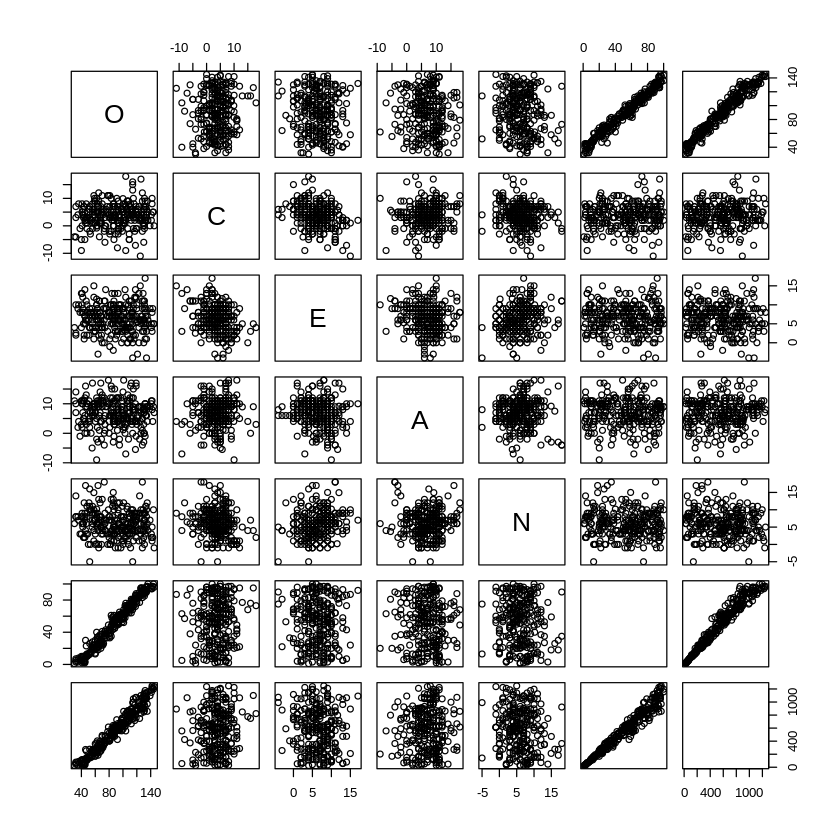

In [24]:
pairs(matriz)
fit1 <- lm(Puntaje~ZO+ZC+ZE+ZA+ZN+ZS+ZO2+ZC2+ZE2+ZA2+ZN2+ZS2+ZOC+ZOE+ZOA+ZON+ZOS+ZCE+ZCA+ZCN+ZCS+ZEA+ZEN+ZES+ZAN+ZAS+ZNS)
summary(fit1)

De lo anterior se pueden concluir muchas cosas. La primera es que al ver la gráfica podemos darnos cuena que hay una alta correlación positiva entre el efecto O y la satisfacción y el Puntaje. Y tambien entre la Satisfacción y el Puntaje, lo que quiere decir que hay multicolinealidad en el modelo. Por ejemplo la variable de satisfacción nos da la misma información que el puntaje, muy probablemente entre máyor fue su puntaje mayor fue su satisfacción. 

Por otro lado con el modelo podemos ver que la mayoría de las variables (lineales) son individualmente significativas, a excepción del efecto E. Mientras que la mayoría de las variables (cuadráticas) no son significativas individualmente, a excepción del efecto O y de la satisfacción. Por último, de las 15 interacciones solo 3 son individualmente significativas (O con A, O con N y A con satisfacción)

Como vemos que las interacciones no son muy significativas para el modelo se decide elimanrlas y crear un nuevo modelo solo con las varaibles lineales y cuadráticas (sin interacción)

In [25]:
fit2 <- lm(Puntaje~ZO+ZC+ZE+ZA+ZN+ZS+ZO2+ZC2+ZE2+ZA2+ZN2+ZS2)
summary(fit2)


Call:
lm(formula = Puntaje ~ ZO + ZC + ZE + ZA + ZN + ZS + ZO2 + ZC2 + 
    ZE2 + ZA2 + ZN2 + ZS2)

Residuals:
     Min       1Q   Median       3Q      Max 
-202.549  -26.508    1.991   32.294  155.916 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 570.74614    6.69800  85.211  < 2e-16 ***
ZO            5.68915    0.67612   8.414 3.31e-15 ***
ZC            1.91316    0.82217   2.327 0.020783 *  
ZE            0.09435    1.01121   0.093 0.925739    
ZA            6.45305    0.76049   8.485 2.07e-15 ***
ZN           -2.16360    0.94161  -2.298 0.022418 *  
ZS            5.26842    0.70447   7.479 1.34e-12 ***
ZO2           0.04348    0.01114   3.905 0.000122 ***
ZC2           0.01766    0.10364   0.170 0.864819    
ZE2           0.15578    0.17781   0.876 0.381821    
ZA2          -0.09723    0.10528  -0.924 0.356617    
ZN2           0.24240    0.14831   1.634 0.103453    
ZS2          -0.03771    0.01305  -2.890 0.004203 ** 
---
Signif. codes:  0 ‘**

Observando los resultados de este nuevo modelo, se puede ver que no es muy diferente los resultados individuales que con respecto al modelo pasado. Lo anterior quiere decir que en su mayiría las variables lineales son las que en efecto son significativas mayoritariamente. Las variables cuadráticas en terminos generales no son significativas (a excepción del efecto O al cuadrado y de la satisfacción al cuadrado) 
Al ver esto se puede llegar a pensar que incluso los efectos cuadráticos no tienen una gran influencia o no son lo suficientemente relevantes y por ende podemos omitirlos y quedarnos solo con un modelo lineal simple.

In [26]:
fit3 <- lm(Puntaje~O+C+E+A+N+S)
summary(fit3)


Call:
lm(formula = Puntaje ~ O + C + E + A + N + S)

Residuals:
     Min       1Q   Median       3Q      Max 
-200.968  -28.723   -0.819   31.675  143.330 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -233.6182    30.8643  -7.569 7.15e-13 ***
O              5.4164     0.6818   7.945 6.56e-14 ***
C              1.5843     0.8383   1.890   0.0599 .  
E             -0.4210     1.0276  -0.410   0.6824    
A              6.7466     0.7546   8.941  < 2e-16 ***
N             -1.7099     0.9358  -1.827   0.0688 .  
S              5.5526     0.7072   7.851 1.20e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 56.01 on 251 degrees of freedom
Multiple R-squared:  0.9709,	Adjusted R-squared:  0.9702 
F-statistic:  1396 on 6 and 251 DF,  p-value: < 2.2e-16


Finalmente, bajo un nivel de confianza del 95% se puede concluir que con un modelo lineal la mayoría de las variables son significativas.  Con un nivel de significancia del 10% la única variable que no es significativa es la del efecto E. 
Teniendo en cuenta todo el análisis anterior se podría llegar a pensar que el efecto de la personalidad sobre la producción intelectual bajo estres, es en su mayoría un efecto lineal, por lo que sus efectos cuadráticos no son lo suficientemente significativos y se pueden omitir, al igual que las interacciones.

### Problema 6. Interacciones y Multicolinealidad.

En la base de datos `mtcars`, se usan las variables continuas: `disp` (desplazamiento), `hp` (potencia), y `wt` (peso del carro). Además, se usan las siguientes variables categóricas: `vs` (dispocición de los cilindrios) y `am` (tipo de transmisión). Use:

In [27]:
library(ISLR)
data <- mtcars
data <- data[c("mpg", "disp", "hp", "wt", "vs", "am")]
head(data)


,mpg,disp,hp,wt,vs,am
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,160,110,2.620,0,1
Mazda RX4 Wag,21.0,160,110,2.875,0,1
Datsun 710,22.8,108,93,2.320,1,1
Hornet 4 Drive,21.4,258,110,3.215,1,0
Hornet Sportabout,18.7,360,175,3.440,0,0
Valiant,18.1,225,105,3.460,1,0


Considere un modelo que contenga las tres variables continuas y las variables categóricas (con todas las interacciones entre continuas y dummies):

\begin{align*}
    mpg &= \quad \beta_{0} \\
        &\quad + \beta_{\text{disp}} \cdot \text{disp} + \beta_{\text{hp}} \cdot \text{hp} + \beta_{\text{wt}} \cdot \text{wt} \\
        &\quad + \gamma_{\text{vs}} + \gamma_{\text{am}} \\
        &\quad + \eta_{\text{disp} \cdot \text{vs}} \cdot \text{disp} \cdot \text{vs} + \eta_{\text{disp} \cdot \text{am}} \cdot \text{disp}\cdot \text{am} + \eta_{\text{hp} \cdot \text{vs}} \cdot \text{hp} \cdot \text{vs} + \eta_{\text{hp} \cdot \text{am}} \cdot \text{hp}\cdot \text{am} + \eta_{\text{wt} \cdot \text{vs}} \cdot \text{wt} \cdot \text{vs} + \eta_{\text{wt} \cdot \text{am}} \cdot \text{wt}\cdot \text{am}
\end{align*}

In [28]:
data_inter <- data
data_inter["disp:vs1"] <- data["disp"] * data["vs"]
data_inter["disp:am1"] <- data["disp"] * data["am"]
data_inter["hp:vs1"]   <- data["hp"] * data["vs"]
data_inter["hp:am1"]   <- data["hp"] * data["am"]
data_inter["wt:vs1"]   <- data["wt"] * data["vs"]
data_inter["wt:am1"]   <- data["wt"] * data["am"]
head(data_inter)


,mpg,disp,hp,wt,vs,am,disp:vs1,disp:am1,hp:vs1,hp:am1,wt:vs1,wt:am1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Mazda RX4,21.0,160,110,2.620,0,1,0,160,0,110,0.000,2.620
Mazda RX4 Wag,21.0,160,110,2.875,0,1,0,160,0,110,0.000,2.875
Datsun 710,22.8,108,93,2.320,1,1,108,108,93,93,2.320,2.320
Hornet 4 Drive,21.4,258,110,3.215,1,0,258,0,110,0,3.215,0.000
Hornet Sportabout,18.7,360,175,3.440,0,0,0,0,0,0,0.000,0.000
Valiant,18.1,225,105,3.460,1,0,225,0,105,0,3.460,0.000


In [57]:
data["wt"][1,]

[1] 2.62

In [45]:
X <- as.matrix(cbind(1, data_inter[, -1]))
head(X)

y <- as.matrix(data_inter["mpg"])
head(y)

,1,disp,hp,wt,vs,am,disp:vs1,disp:am1,hp:vs1,hp:am1,wt:vs1,wt:am1
Mazda RX4,1,160,110,2.620,0,1,0,160,0,110,0.000,2.620
Mazda RX4 Wag,1,160,110,2.875,0,1,0,160,0,110,0.000,2.875
Datsun 710,1,108,93,2.320,1,1,108,108,93,93,2.320,2.320
Hornet 4 Drive,1,258,110,3.215,1,0,258,0,110,0,3.215,0.000
Hornet Sportabout,1,360,175,3.440,0,0,0,0,0,0,0.000,0.000
Valiant,1,225,105,3.460,1,0,225,0,105,0,3.460,0.000


,mpg
Mazda RX4,21.0
Mazda RX4 Wag,21.0
Datsun 710,22.8
Hornet 4 Drive,21.4
Hornet Sportabout,18.7
Valiant,18.1


In [46]:
modelo_1 <- lm(mpg ~ ., data = data_inter)
summary(modelo_1)



Call:
lm(formula = mpg ~ ., data = data_inter)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.9216 -1.4889 -0.2435  1.2442  3.7930 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 28.414403   3.692353   7.695 2.11e-07 ***
disp         0.003009   0.014012   0.215   0.8321    
hp          -0.026448   0.021663  -1.221   0.2363    
wt          -2.254464   1.378400  -1.636   0.1176    
vs           5.179986   5.976364   0.867   0.3964    
am          12.707423   7.176812   1.771   0.0919 .  
`disp:vs1`  -0.007544   0.024742  -0.305   0.7636    
`disp:am1`  -0.019471   0.024738  -0.787   0.4405    
`hp:vs1`    -0.064872   0.035753  -1.814   0.0846 .  
`hp:am1`     0.034913   0.030616   1.140   0.2676    
`wt:vs1`     1.371658   2.878683   0.476   0.6389    
`wt:am1`    -4.609291   2.963323  -1.555   0.1355    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.271 on 20 degrees of freedom
Multiple R-square

#### 1. ¿Influye el tipo de caja en los modelos?

Debemos probar las siguientes hipótesis:

\begin{align*}
    H_{0}: &\quad \gamma_{am} = 0 \\
           &\land \eta_{\text{disp} \cdot \text{am}} = 0 \\
           &\land \eta_{\text{hp} \cdot \text{am}} = 0 \\
           &\land \eta_{\text{wt} \cdot \text{am}} = 0 \\
    H_{a}: &\quad \neg H_{0}
\end{align*}

Usamos una de las funciones implementada en el problema 1 de esta tarea.

In [47]:
p_val <- function(X, y, n, p, q, A, c) {

    xtx <- t(X) %*% X
    H <- solve(xtx)

    beta_hat <- H %*% t(X) %*% y

    y_hat <- X %*% beta_hat

    s2 <- sum((y - y_hat) ^ 2) / (n - p)

    beta_r <- beta_hat +
              (H %*% t(A)
               %*% solve(A %*% H %*% t(A))
               %*% (c - (A %*% beta_hat)))

    ep <- (sum((y_hat - (X %*% beta_r)) ^ 2) / q) / s2

    pvalue <- 1 - pf(ep, q, (n - p))

    return(c(ep, pvalue))

}

In [49]:
A <- matrix(c(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), nrow = 4, byrow = TRUE)

n <- nrow(X)
p <- ncol(X)
q <- nrow(A)

c <- matrix(0, nrow = q)

p_val(X, y, n, p, q, A, c)

[1] 1.09134 0.38764

Con un $\alpha = 0.05$, no rechazamos la hipótesis nula y afirmamos que el tipo de caja no influye en el modelo.

#### 2. ¿Vale la pena considerar las interacciones en los modelos, o son todos paralelos?

Debemos probar las siguientes hipótesis:

\begin{align*}
    H_{0}: &\quad \eta_{\text{disp} \cdot \text{am}} = 0 \\
           &\land \eta_{\text{hp} \cdot \text{am}} = 0 \\
           &\land \eta_{\text{wt} \cdot \text{am}} = 0 \\
           &\land \eta_{\text{disp} \cdot \text{vs}} = 0 \\
           &\land \eta_{\text{hp} \cdot \text{vs}} = 0 \\
           &\land \eta_{\text{wt} \cdot \text{vs}} = 0 \\
    H_{a}: &\quad \neg H_{0}
\end{align*}

In [51]:
A <- matrix(c(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1), nrow = 6, byrow = TRUE)

n <- nrow(X)
p <- ncol(X)
q <- nrow(A)

c <- matrix(0, nrow = q)

p_val(X, y, n, p, q, A, c)

[1] 1.9786812 0.1169711

Con un $\alpha = 0.05$, no rechazamos la hipótesis nula y afirmamos que los coeficientes de las interacciones son iguales a 0.

#### 3. ¿Es igual el efecto de la variable `wt` en el consumo de combustible para la caja manual con motor en línea que para caja automática con motor en `v`?

Debemos probar las siguientes hipótesis:

\begin{align*}
    H_{0}: & \eta_{\text{wt} \cdot \text{am}} + \eta_{\text{wt} \cdot \text{vs}} = 0 \\
    H_{a}: & \neg H_{0}
\end{align*}

In [54]:
A <- matrix(c(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1), nrow = 1, byrow = TRUE)

n <- nrow(X)
p <- ncol(X)
q <- nrow(A)

c <- matrix(0, nrow = q)

p_val(X, y, n, p, q, A, c)

[1] 1.3075857 0.2663354

Con un $\alpha = 0.05$, no rechazamos la hipótesis nula y afirmamos que el efecto de la variable `wt` es igual en ambos casos.

#### 4. ¿Es igual el modelo para la caja manual con motor en línea que para caja automática con motor en v?

Debemos probar las siguientes hipótesis:

\begin{align*}
    H_{0}: & \gamma_{am} + \gamma_{vs} + \eta_{\text{disp} \cdot \text{am}} + \eta_{\text{disp} \cdot \text{vs}} + \eta_{\text{hp} \cdot \text{am}} + \eta_{\text{hp} \cdot \text{vs}} + \eta_{\text{wt} \cdot \text{am}} + \eta_{\text{wt} \cdot \text{vs}} = 0 \\
    H_{a}: & \neg H_{0}
\end{align*}

In [55]:
A <- matrix(c(0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1), nrow = 1, byrow = TRUE)

n <- nrow(X)
p <- ncol(X)
q <- nrow(A)

c <- matrix(0, nrow = q)

p_val(X, y, n, p, q, A, c)

[1] 12.453110675  0.002109114

Con un $\alpha = 0.05$, no rechazamos la hipótesis nula y afirmamos que el efecto de la variable `wt` es igual en ambos casos.

#### 5. Un vendedor ofrece dos modelos. El carro 1 tiene `disp=20`, `hp=150`, `wt=1.5`, caja manual y motor en v. El carro 2 tiene `disp=17`, `hp=100`, `wt=2.6`, caja automática y motor en línea. El vendedor afirma que los consumos medios de combustible son respectivamente $18$ y $21$. ¿Es cierta la afirmación del vendedor?

Debemos probar las siguientes hipótesis:

\begin{align*}
    H_{0}: & \quad \beta_{0} + 20 \cdot \beta_{\text{disp}} + 150 \cdot \beta_{\text{hp}} + 1.5 \cdot \beta_{\text{wt}} + \gamma_{\text{am}} + 20 \cdot \eta_{\text{disp} \cdot \text{am}} + 150 \cdot \eta_{\text{hp} \cdot \text{am}} + 1.5 \cdot \eta_{\text{wt} \cdot \text{am}} = 18 \\
           & \land \beta_{0} + 17 \cdot \beta_{\text{disp}} + 100 \cdot \beta_{\text{hp}} + 2.6 \cdot \beta_{\text{wt}} + \gamma_{\text{vs}} + 17 \cdot \eta_{\text{disp} \cdot \text{vs}} + 100 \cdot \eta_{\text{hp} \cdot \text{vs}} + 2.6 \cdot \eta_{\text{wt} \cdot \text{vs}} = 21 \\
    H_{a}: & \neg H_{0}
\end{align*}

In [60]:
A <- matrix(c(1, 20, 150, 1.5, 0, 1, 0, 20, 0, 150, 0, 1.5,
              1, 17, 100, 2.6, 1, 0, 17, 0, 100, 0, 2.6, 0), nrow = 2, byrow = TRUE)

n <- nrow(X)
p <- ncol(X)
q <- nrow(A)

c <- matrix(c(18, 21), nrow = q)

p_val(X, y, n, p, q, A, c)

[1] 4.41006281 0.02590247

Con un $\alpha = 0.05$, no rechazamos la hipótesis nula y concluimos que la afirmación del vendedor es acertada.

#### 6. Al parecer las pruebas tienden a no dar significativas en los puntos anteriores. Pruebe que el modelo tiene problemas de multicolinealidad, y explique qué relación tiene esto con las interacciones que se inluyen en el modelo.

In [63]:
library(car)
vif(modelo_1)


disp         hp         wt         vs         am `disp:vs1` `disp:am1` 
  18.13442   13.26515   10.93805   54.55923   77.11764   21.40307   29.70958 
  `hp:vs1`   `hp:am1`   `wt:vs1`   `wt:am1` 
  18.22026   37.99965   96.99903   84.20720

Aunque parece que todos los beta tienen un factor de inflación de la varianza bastante grande, particularmente las interacciones son preocupantes.

En poca medida, puede deberse un poco la multicolinealidad a las medidas de desplazamiento, peso y caballos de fuerza, ya que es de esperarse que estén inversamente relacionadas. Un alto número de caballos de fuerza del motor puede significar que no está optimizado para desplazarse, sino para efectuar un gran torque, lo cual implicaría un motor más pesado y con menor capacidad de desplazamiento.

Principalmente la multicolinealidad presente en el modelo podría explicarse por las variables de interacción, donde estas son directamente el resultado de variables que ya existen en el modelo sin interacciones. Es evidente que las variables de interacción dependen linealmente de las variables sencillas y por lo tanto están correlacionadas e introducen multicolinealidad. Más aún, las variables binarias tienen un efecto mucho más drástico en las variables de interacción, ya que un valor de 0 en una variable binaria perfectamente determina un 0 en sus respectivas interacciones.

#### 7. Corra el modelo sin intereacciones y determine si siguen existiendo problemas de multicolinealidad.

In [66]:
modelo_2 <- lm(mpg ~ ., data = data)
summary(modelo_2)



Call:
lm(formula = mpg ~ ., data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7847 -1.8458 -0.3776  1.4665  5.1560 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31.040531   3.409758   9.103 1.44e-09 ***
disp         0.009473   0.011040   0.858  0.39873    
hp          -0.035040   0.012412  -2.823  0.00900 ** 
wt          -3.149865   1.128801  -2.790  0.00973 ** 
vs           2.288891   1.456995   1.571  0.12828    
am           2.798663   1.455738   1.923  0.06556 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.514 on 26 degrees of freedom
Multiple R-squared:  0.8541,	Adjusted R-squared:  0.826 
F-statistic: 30.44 on 5 and 26 DF,  p-value: 4.421e-10


In [67]:
vif(modelo_2)

disp       hp       wt       vs       am 
9.184048 3.552448 5.983939 2.645290 2.588332

En este nuevo modelo podemos estar satisfechos con los vif de las variables. Ninguna es mayor a 10 y en su mayoría, son menores a 10. Un potencial candidato a no incluir en el modelo es la variable `disp`, aunque no es una medida que deba efectuarse con urgencia.